In [4]:
import joblib
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

from torp.io.torp_dataset import TORPDataset, DEFAULT_FEATURES
import matplotlib.pyplot as plt 
import seaborn as sns
from bayeshist import bayesian_histogram, plot_bayesian_histogram
import numpy as np
import pandas as pd

In [ ]:
# This repo has code for validating ML models and plotting utilies 
!git clone https://github.com/monte-flora/verification_diagrams

In [18]:
import sys
sys.path.append('/home/monte.flora/python_packages/verification_diagrams')

from verification_diagrams import sklearn_curve_bootstrap, VerificationDiagram
import matplotlib.patches as patches

In [6]:
N_BOOT = 10 
dataset = TORPDataset(dirpath='/work2/mflora/torp_datasets/ML_data',
                      years=[2018], 
                     )
df = dataset.load_dataframe()
target_variable = 'tornado'
X, y = df[DEFAULT_FEATURES], df[target_variable]
years = df['year']

In [7]:
model_data = joblib.load('random_forest_torp.joblib')

In [9]:
model_data.keys()

dict_keys(['model', 'X', 'y'])

In [15]:
model = model_data['model']

y_pred = model.predict_proba(X)[:,1]
y_true = y.values 

In [16]:
line_colors = [ 'xkcd:blood orange']

data = {
    'RF' : {
        'y_pred' : y_pred,
        'y_true' : y_true,
        'group'  : None
    }
}

names = ['RF']
_xx={}
_yy={}
_scores={}
scores={name:{} for name in names}

for name in names: 
    xx, yy, score = sklearn_curve_bootstrap(data[name]['y_true'], 
                                         data[name]['y_pred'], 
                                         metric='performance', 
                                         n_boot=N_BOOT, 
                                        groups=data[name]['group'], 
                            random_seed=42)
    _scores[name]=score
    for metric in score:
        scores[name][metric]=np.nanmean(score[metric])
    _xx[name]=xx
    _yy[name]=yy

Text(0.060506596837546577, 0.5, 'No Skill Region')

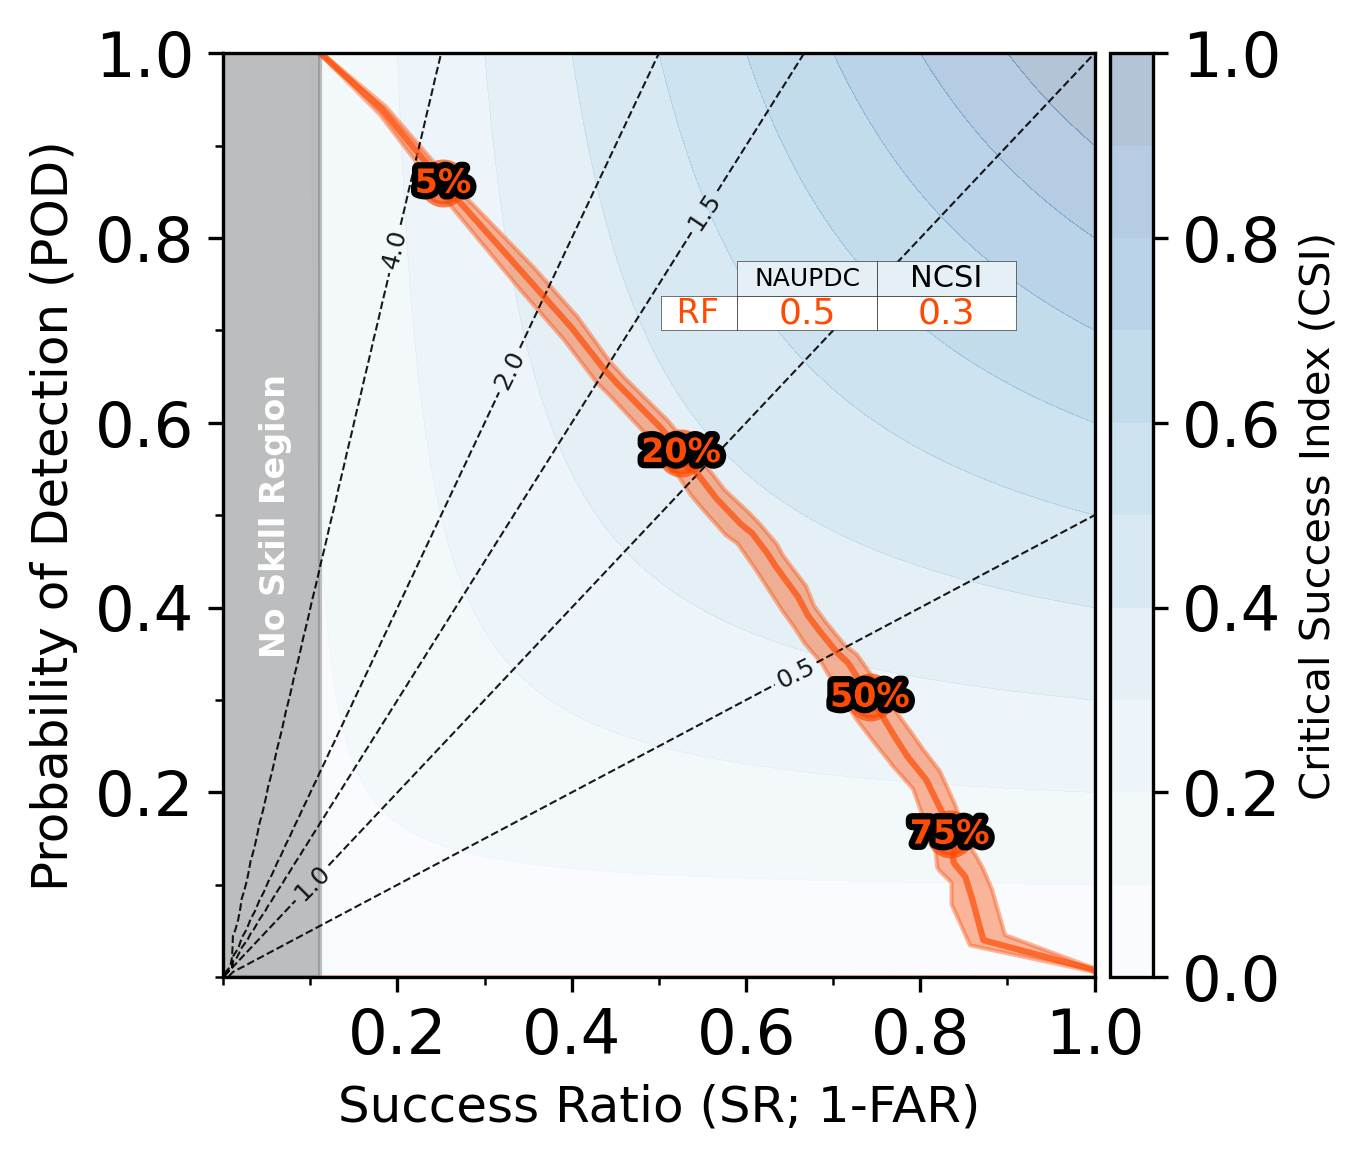

In [19]:
vd = VerificationDiagram(y_pred  = {name: data[name]['y_pred'] for name in names})

ax = vd.plot('performance', _xx, _yy, scores=_scores,  add_dots=True, 
             add_max_marker=True, table_fontsize=8,  table_alpha=1, 
             line_colors=line_colors,
             plot_kwargs={'line_colors':line_colors},
             prob_thresh = np.arange(0, 1.025, 0.025),
             selected_thresh = [0.05, 0.2, 0.5, 0.75],
             annot_kws = {
                          #'dot_font_color' : 'gray', 
                          'dot_font_size' : 8,
                          'dot_size' : 100,
                         }
             #table_bbox=[0.75, 0.65, 0.25, 0.4]
            )

# Add a rectangle to shade part of the axes
br = np.mean(y_true)
rect = patches.Rectangle((0, 0), br, 1, color='gray', alpha=0.5)
ax.add_patch(rect)

# Add annotation within the shaded area
ax.text(br / 2 + 0.005, 0.5, 'No Skill Region', ha='center', va='center', rotation=90,
        color='white', fontsize=8, weight='bold')

In [20]:
%%time

_xx={}
_yy={}
_scores={}
scores={name:{} for name in names}

for name in names: 
    xx, yy, score = sklearn_curve_bootstrap(data[name]['y_true'], 
                                            data[name]['y_pred'], 
                                            metric='reliability', 
                                            n_boot=N_BOOT, 
                                            groups=data[name]['group'], 
                                            random_seed=42
                                           )
    _scores[name]=score
    for metric in score:
        scores[name][metric]=np.nanmean(score[metric])
    _xx[name]=xx
    _yy[name]=yy
    

CPU times: user 93 ms, sys: 2.65 ms, total: 95.7 ms
Wall time: 95.2 ms


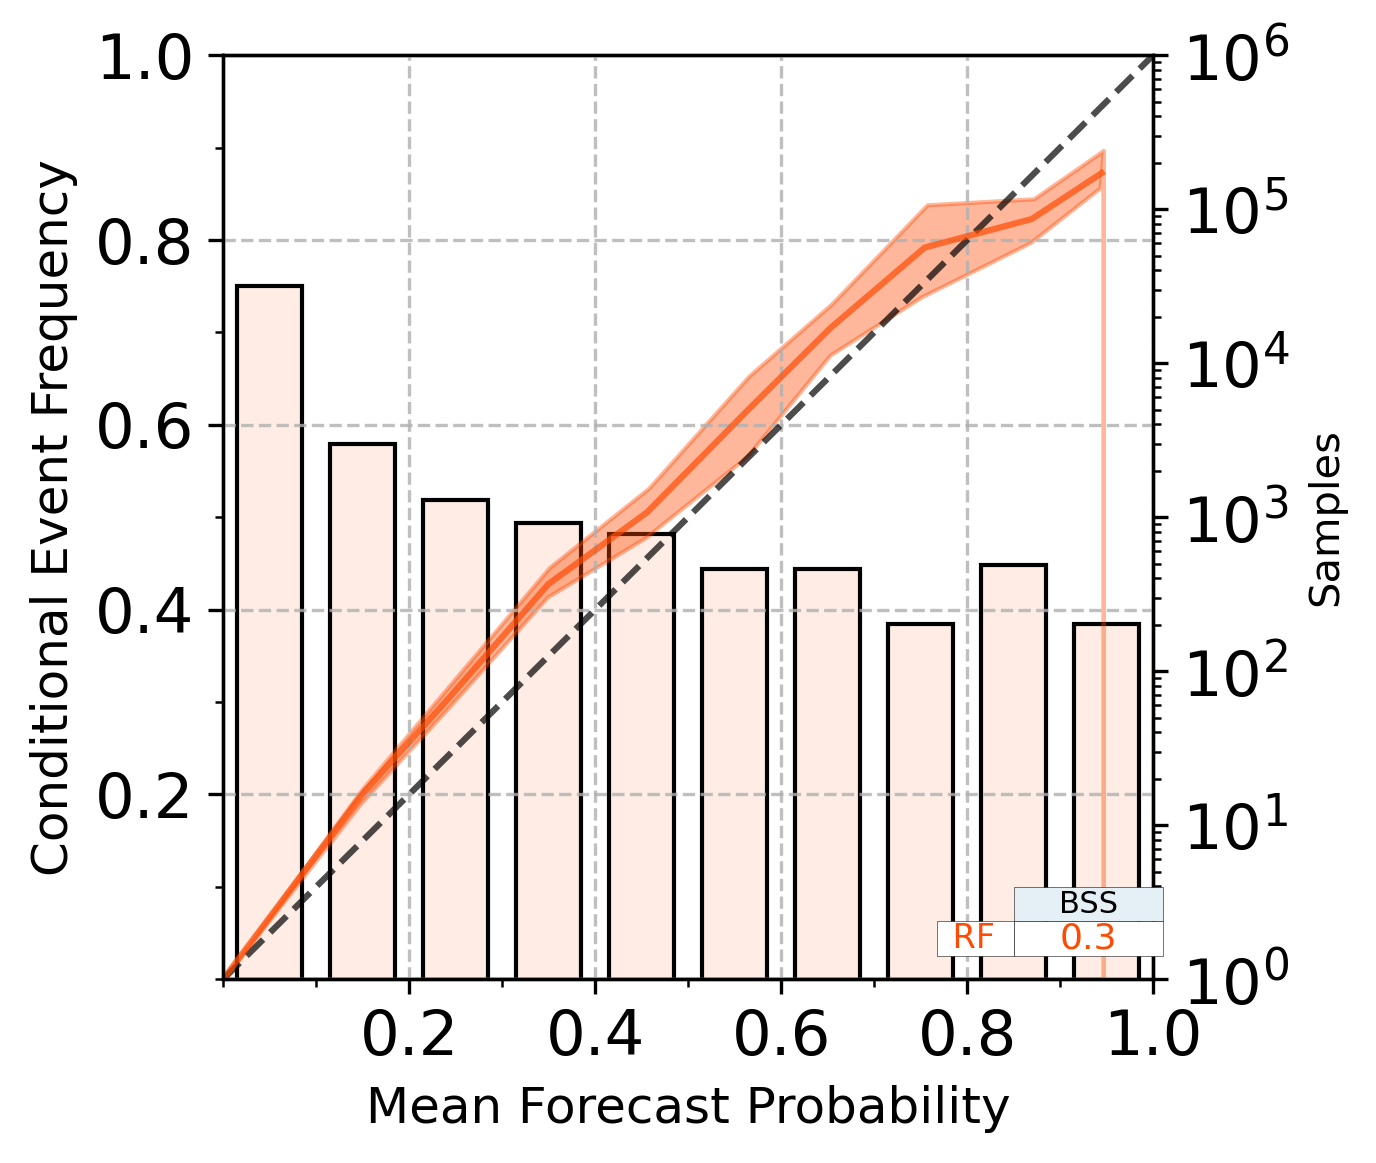

In [21]:
vd = VerificationDiagram(y_pred  = {name: data[name]['y_pred'] for name in names})
ax = vd.plot('reliability', _xx, _yy, scores=_scores,  add_dots=False, 
             add_max_marker=True, table_fontsize=8,  table_alpha=1, 
             line_colors=line_colors,
             plot_kwargs={'line_colors':line_colors},
             #table_bbox=[0.75, 0.65, 0.25, 0.4]
            )